# Survival Evaluation

This notebook evaluates the unvalidated survival experiments.

In [1]:
import os
import pickle

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import utilities.plotting as plots
import utilities.preprocess_raw_data as prep_data
import utilities.generate_survival_dataset as gen_surv
import utilities.latex_figures as latex_figs

In [2]:
SAVE_FIGS = True

In [3]:
load_dotenv()
EXPERIMENT = os.environ.get("EXPERIMENT_NUMBER")
print(f"The experiment number is {EXPERIMENT}")

The experiment number is 10


## Input Data Evaluation

### Augmentation Effects on the Dataset

In [4]:
raw_df = pd.read_parquet("./data/my_datasets/raw_merged.parquet")

In [5]:
EXAMPLE_DEV = "bea4cb80-2734-4a71-8ff6-602129e653a4"

In [6]:
raw_df = raw_df[raw_df["device_uuid"] == EXAMPLE_DEV]

In [7]:
base_df = prep_data.load_base_dataset(raw_merged_df=raw_df)

In [8]:
aug_noise_5 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, add_noise=True, max_noise=5
)
aug_noise_10 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, add_noise=True, max_noise=10
)
aug_noise_20 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, add_noise=True, max_noise=20
)

In [9]:
aug_time_warp_05 = prep_data.load_base_dataset(
    raw_merged_df=raw_df,
    random_warp_status_times=True,
    random_max_time_warp_percent=0.5,
)
aug_time_warp_1 = prep_data.load_base_dataset(
    raw_merged_df=raw_df,
    random_warp_status_times=True,
    random_max_time_warp_percent=1.0,
)
aug_time_warp_2 = prep_data.load_base_dataset(
    raw_merged_df=raw_df,
    random_warp_status_times=True,
    random_max_time_warp_percent=2.0,
)

In [10]:
aug_fixed_time_shifting_02 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, fixed_warp_status_times=True, fixed_warping_percent=0.2
)
aug_fixed_time_shifting_neg02 = prep_data.load_base_dataset(
    raw_merged_df=raw_df, fixed_warp_status_times=True, fixed_warping_percent=-0.2
)

In [11]:
plots.plot_compare_multiple_dfs(
    [
        (raw_df, "battery_level_percent", EXAMPLE_DEV, "raw", True),
        (base_df, "battery_level_percent", EXAMPLE_DEV, "preprocessed", True),
        (aug_noise_5, "battery_level_percent", EXAMPLE_DEV, "5% noise", True),
        (aug_noise_10, "battery_level_percent", EXAMPLE_DEV, "10% noise", True),
        (aug_noise_20, "battery_level_percent", EXAMPLE_DEV, "20% noise", True),
        (
            aug_time_warp_05,
            "battery_level_percent",
            EXAMPLE_DEV,
            "up to 50% random time warping",
            True,
        ),
        (
            aug_time_warp_1,
            "battery_level_percent",
            EXAMPLE_DEV,
            "up to 100% random time warping",
            True,
        ),
        (
            aug_time_warp_2,
            "battery_level_percent",
            EXAMPLE_DEV,
            "up to 200% random time warping",
            True,
        ),
    ]
)

In [12]:
plots.plot_cycles(base_df)

### Input Feature Correlation

In [13]:
surv_df = gen_surv.base_to_survival_dataset(base_df)

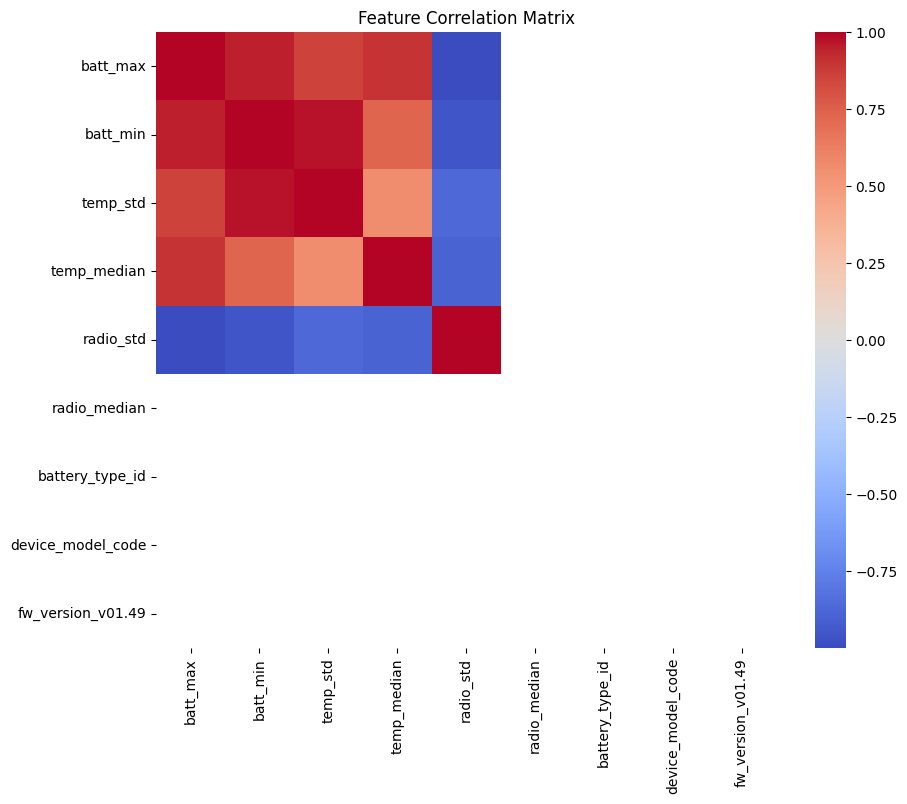

In [14]:
plt.figure(figsize=(10, 8))
correlation_matrix = surv_df.drop(
    columns=[
        "device_uuid",
        "cycle_id",
        "duration",
        "event",
    ],
).corr()
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

## Model Evaluation

### Model Performance Evaluation

#### Effect of Augmentation on the Model Performance

In [15]:
runs_df = pd.read_csv(f"./data/runs/surv_runs_{EXPERIMENT}.csv")
runs_df["params.n_aug"] = runs_df["params.n_aug"].astype(str)

In [16]:
def print_best_n_models(runs_df: pd.DataFrame, n_lines_to_print: int):
    metric_to_name = {"metrics.c_index_ipcw": "C-Index IPCW", "metrics.ibs": "IBS"}

    pd.options.display.float_format = "{:.3f}".format

    for n_dev in sorted(runs_df["params.n_dev"].unique()):
        print("#####################################################")
        print(f"Best models for {n_dev} devices:")
        print("#####################################################")
        for by_metric in metric_to_name.keys():
            interesting_columns = [
                "params.model_class",
                "params.n_aug",
            ]
            interesting_columns.append(by_metric)
            runs_df = runs_df.sort_values(
                by=[by_metric], ascending=by_metric != "metrics.c_index_ipcw"
            )

            print("-----------------")
            print(f"By metric {metric_to_name[by_metric]}:")
            print("-----------------")

            best = (
                runs_df[(runs_df["params.n_dev"] == n_dev)][interesting_columns]
                .head(n_lines_to_print)
                .reset_index(drop=True)
            )
            map = {col: col.split(".")[1] for col in interesting_columns}
            print(
                best.rename(
                    mapper=map,
                    axis="columns",
                )
            )
            print()

            best_metric = best.head(1)[by_metric].values[0]
            best_no_aug = (
                runs_df[
                    (runs_df["params.n_dev"] == n_dev)
                    & (runs_df["params.n_aug"] == "0")
                ][interesting_columns]
                .head(1)
                .reset_index(drop=True)
            )

            if all(best["params.n_aug"] != "0"):
                print("Best model with no augmentation:")
                print(
                    best_no_aug.rename(
                        mapper=map,
                        axis="columns",
                    )
                )

            best_no_aug_metric = best_no_aug[by_metric].values[0]
            print()
            if by_metric == "metrics.c_index_ipcw":
                improvement = best_metric - best_no_aug_metric
            else:
                improvement = best_no_aug_metric - best_metric
            improvement_percent = improvement / best_no_aug_metric * 100
            print(
                f"{metric_to_name[by_metric]} improvement through augmentation: {improvement:.3f} ({improvement_percent:.1f}%)"
            )
            print()

In [17]:
print_best_n_models(runs_df, 5)

#####################################################
Best models for 10 devices:
#####################################################
-----------------
By metric C-Index IPCW:
-----------------
            model_class n_aug  c_index_ipcw
0  RandomSurvivalForest     5         0.948
1  RandomSurvivalForest     3         0.945
2  RandomSurvivalForest     3         0.941
3  RandomSurvivalForest     3         0.937
4  RandomSurvivalForest     1         0.933

Best model with no augmentation:
            model_class n_aug  c_index_ipcw
0  RandomSurvivalForest     0         0.877

C-Index IPCW improvement through augmentation: 0.071 (8.1%)

-----------------
By metric IBS:
-----------------
   model_class n_aug   ibs
0  CoxPHFitter     3 0.065
1  CoxPHFitter     3 0.067
2  CoxPHFitter     5 0.067
3  CoxPHFitter    10 0.068
4  CoxPHFitter     5 0.069

Best model with no augmentation:
   model_class n_aug   ibs
0  CoxPHFitter     0 0.080

IBS improvement through augmentation: 0.015 (19.3%)

#

In [18]:
print_best_n_models(runs_df, 2)

#####################################################
Best models for 10 devices:
#####################################################
-----------------
By metric C-Index IPCW:
-----------------
            model_class n_aug  c_index_ipcw
0  RandomSurvivalForest     5         0.948
1  RandomSurvivalForest     3         0.945

Best model with no augmentation:
            model_class n_aug  c_index_ipcw
0  RandomSurvivalForest     0         0.877

C-Index IPCW improvement through augmentation: 0.071 (8.1%)

-----------------
By metric IBS:
-----------------
   model_class n_aug   ibs
0  CoxPHFitter     3 0.065
1  CoxPHFitter     3 0.067

Best model with no augmentation:
   model_class n_aug   ibs
0  CoxPHFitter     0 0.080

IBS improvement through augmentation: 0.015 (19.3%)

#####################################################
Best models for 20 devices:
#####################################################
-----------------
By metric C-Index IPCW:
-----------------
            model_

In [19]:
fig_grid = latex_figs.LatexSubfigureGrid(
    label="comp_n_aug_c-index",
    caption="Vergleich der Augmentierungsmenge mit dem \gls{c_index_ipcw}, Unterteilt nach Anzahl der Trainingsgeräte.",
)

for n_dev in sorted(runs_df["params.n_dev"].unique(), reverse=False):
    plot_df = runs_df.sort_values(by=["params.model_class"], ascending=True)[
        (runs_df["params.n_dev"] == n_dev)
    ]

    plot_df = plot_df[plot_df["metrics.c_index_ipcw"] != 0.5]

    x_order = ["0", "1", "3", "5"]

    title = f"Vergleich der Augmentierungsmenge mit dem C-Index IPCW für {n_dev} Trainingsgeräte."
    fig = px.box(
        plot_df,
        x="params.n_aug",
        y="metrics.c_index_ipcw",
        color="params.model_class",
        title=title,
        points="all",
        category_orders={"params.n_aug": x_order},
        width=1000,
        height=600,
    )
    fig.update_yaxes(range=[0.5, 1], title="C-Index IPCW")
    fig.update_xaxes(title="Augmentierte Trainingsdaten zu realen Trainingsdaten n:1")
    fig.show()
    if SAVE_FIGS:
        subfig = latex_figs.LatexSubfigure(
            f"resources/figures/survival_results/comp_n_aug_{n_dev}_c-index.png",
            fig,
            caption=f"{n_dev} Trainingsgeräte",
        )
        fig_grid.add_subfigure(subfig)
        fig_grid.add_newline()

fig_grid.save_figure()
fig_grid.write_latex_code_to_file(
    "comp_n_aug_c-index.tex"
)

/tmp/ipykernel_19411/4221768986.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/tmp/ipykernel_19411/4221768986.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/tmp/ipykernel_19411/4221768986.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/tmp/ipykernel_19411/4221768986.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_10_c-index.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_20_c-index.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_40_c-index.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_63_c-index.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/comp_n_aug_c-index.tex
Done!


In [20]:
fig_grid = latex_figs.LatexSubfigureGrid(
    label="comp_n_aug_ibs",
    caption="Vergleich der Augmentierungsmenge mit dem \gls{ibs}, Unterteilt nach Anzahl der Trainingsgeräten.",
)

for n_dev in sorted(runs_df["params.n_dev"].unique(), reverse=False):
    plot_df = runs_df.sort_values(by=["params.model_class"], ascending=True)[
        (runs_df["params.n_dev"] == n_dev)
    ]

    x_order = ["0", "1", "3", "5"]

    title = (
        f"Vergleich der Augmentierungsmenge mit dem IBS für {n_dev} Trainingsgeräte."
    )
    fig = px.box(
        plot_df,
        x="params.n_aug",
        y="metrics.ibs",
        color="params.model_class",
        title=title,
        points="all",
        category_orders={"params.n_aug": x_order},
        width=1000,
        height=600,
    )
    fig.update_yaxes(range=[0, 0.25], title="IBS")
    fig.update_xaxes(title="Augmentierte Trainingsdaten zu realen Trainingsdaten n:1")
    fig.show()
    if SAVE_FIGS:
        subfig = latex_figs.LatexSubfigure(
            f"resources/figures/survival_results/comp_n_aug_{n_dev}_ibs.png",
            fig,
            caption=f"{n_dev} Trainingsgeräte",
        )
        fig_grid.add_subfigure(subfig)
        fig_grid.add_newline()
fig_grid.save_figure()
fig_grid.write_latex_code_to_file(
    "comp_n_aug_ibs.tex"
)

/tmp/ipykernel_19411/3846799290.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/tmp/ipykernel_19411/3846799290.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/tmp/ipykernel_19411/3846799290.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/tmp/ipykernel_19411/3846799290.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_10_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_20_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_40_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/comp_n_aug_63_ibs.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/comp_n_aug_ibs.tex
Done!


In [21]:
col_to_name = {
    "metrics.c_index_ipcw": "C-Index IPCW",
    "metrics.ibs": "IBS",
    "params.n_aug": "Augmentationsanteil",
    "params.n_dev": "Anzahl der Trainingsgeräte",
    "params.noise_temperature": "Jitterstärke auf Lufttemperatur",
    "params.noise": "Jitterstärke auf Batterielevel",
    "params.rand_warp": "Jitterstärke auf Messpunktabstände",
    "params.model_class": "Modelltyp",
}

col_to_full_desc = {
    "params.n_dev": "der Anzahl der Trainingsgeräte",
    "params.n_aug": "des Augmentationsanteils",
    "params.noise": "der Jitterstärke auf Batterielevel",
    "params.rand_warp": "der Jitterstärke auf Messpunktabstände",
    "params.noise_temperature": "der Jitterstärke auf Lufttemperatur",
    "params.model_class": "des Modelltyps",
}

for METRIC in ["metrics.c_index_ipcw", "metrics.ibs"]:
    metric_suffix = METRIC.split(".")[1]
    fig_grid = latex_figs.LatexSubfigureGrid(
        label=f"effect_params_{metric_suffix}",
        caption=f"Einfluss von Augmentationsparametern und Modelltyp auf den \gls{{{metric_suffix}}}",
    )
    for col in [
        col
        for col in col_to_full_desc.keys()
        if "params" in col
        and col
        not in [
            "params.fixed_warp",
            "params.n_dev",
            "params.n_jobs",
            "params.model_class_id",
            "params.penalizer",
        ]
    ]:
        print(col)
        col_suffix = col.split(".")[1]
        df_plot = runs_df.copy()
        # df_plot = df_plot.dropna(axis="index")
        if METRIC == "metrics.c_index_ipcw":
            df_plot = df_plot[df_plot["tags.model_type"] != "kaplan_meier_estimator"]
        df_plot["params.n_dev"] = df_plot["params.n_dev"].astype("str")
        df_plot = df_plot.rename(
            mapper=col_to_name,
            axis="columns",
        )
        title_col_desc = col_to_full_desc[col]
        col = col_to_name[col]
        metric_name = col_to_name[METRIC]

        if isinstance(df_plot[col].iloc[0], str):
            try:
                df_plot[col] = df_plot[col].astype("int")
            except:
                try:
                    df_plot[col] = df_plot[col].astype("float")
                except:
                    pass
        df_plot.sort_values(by=[col], inplace=True)


        fig = px.box(
            df_plot,
            color=col,
            y=metric_name,
            x=col_to_name["params.n_dev"],
            points="all",
            category_orders={
                col_to_name["params.n_dev"]: sorted(
                    df_plot[col_to_name["params.n_dev"]].unique()
                )
            },
            title=f"Einfluss {title_col_desc} auf den {metric_name}",
            width=1000,
            height=600,
        )
        if METRIC == "metrics.c_index_ipcw":
            fig.update_yaxes(range=[0.5, 1])
        fig.show()
        if SAVE_FIGS:
            metric_gls = f"\\gls{{{metric_suffix}}}"
            caption = f"Einfluss {title_col_desc} auf den {metric_gls}"
            subfigure = latex_figs.LatexSubfigure(
                f"resources/figures/survival_results/effect_{col_suffix}_{metric_suffix}.png",
                fig,
                caption=caption,
            )
            fig_grid.add_subfigure(subfigure)
            fig_grid.add_newline()
    
    if SAVE_FIGS:
        fig_grid.save_figure()
        fig_grid.write_latex_code_to_file(
            f"effect_params_{metric_suffix}.tex"
        )

params.n_aug


params.noise


params.rand_warp


params.noise_temperature


params.model_class


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_n_aug_c_index_ipcw.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_noise_c_index_ipcw.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_rand_warp_c_index_ipcw.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_noise_temperature_c_index_ipcw.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_model_class_c_index_ipcw.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/effect_params_c_index_ipcw.tex
Done!
params.n_aug


params.noise


params.rand_warp


params.noise_temperature


params.model_class


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_n_aug_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_noise_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_rand_warp_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_noise_temperature_ibs.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_results/effect_model_class_ibs.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/effect_params_ibs.tex
Done!


### Survival Curve Evaluation

In [22]:
runs_df[runs_df["params.n_dev"] == 10].sort_values(by=["metrics.ibs"]).head(1)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.c_index_censored,metrics.c_index_ipcw,metrics.ibs,params.n_aug,...,params.model_class_id,params.fixed_warp,params.rand_warp,params.noise_temperature,params.penalizer,tags.mlflow.source.name,tags.mlflow.user,tags.model_type,tags.mlflow.source.type,tags.mlflow.runName
181,cb4d7937054647b29a680c5bf390b964,481818478675840006,FINISHED,/home/nkuechen/Documents/Thesis/mlruns/4818184...,2024-06-23 11:04:51.496000+00:00,2024-06-23 11:04:51.843000+00:00,0.906,0.888,0.065,3,...,1,0.000,0.500,5.000,0.010,survival_experiment_training.py,nkuechen,CoxPHFitter,LOCAL,CoxPHFitter_n_dev=10|n_aug=3|noise=20|noise_te...


In [47]:
best_models = {}
for n_dev in sorted(runs_df["params.n_dev"].unique()):
    best_models[n_dev] = {}
    for model_class in ["kaplan_meier_estimator", "CoxPHFitter", "RandomSurvivalForest"]:
        tmp_df = runs_df[
            (runs_df["params.n_dev"] == n_dev)
            & (runs_df["params.model_class"] == model_class)
        ].sort_values(by=["metrics.ibs"], ascending=True)
        best_model = tmp_df.iloc[0]
        
        best_models[n_dev][model_class] = {
            "artifact_uri": best_model["artifact_uri"],
            "c_index_ipcw": best_model["metrics.c_index_ipcw"],
            "ibs": best_model["metrics.ibs"],
            "n_aug": best_model["params.n_aug"],
        }

In [48]:
def duration_to_n_in_cycle(cycle_df: pd.DataFrame, n: float = 20.0) -> int:
    start_date = cycle_df["status_time"].min()
    sub_df = cycle_df[cycle_df["battery_level_percent"] >= n]
    end_date = sub_df["status_time"].max()
    return (end_date - start_date).days

In [53]:
from typing import Iterable


KEEP_CENSORED = True

model_class_to_abbr = {
    "kaplan_meier_estimator": "km",
    "CoxPHFitter": "cph",
    "RandomSurvivalForest": "rsf",
}

for n_dev, best_models_for_n_dev in best_models.items():
    if SAVE_FIGS:
        subfig_grid = latex_figs.LatexSubfigureGrid(
            caption=f"Vorhersagen von besten Modellen trainiert auf {n_dev} Trainingsgeräten.",
            label=f"inf_surv_{n_dev}",
        )
    for model_class, best_models_for_model_class in best_models_for_n_dev.items():
        print(model_class)
        artifact_uri = best_models_for_model_class["artifact_uri"]
        c_index_ipcw = best_models_for_model_class["c_index_ipcw"]
        ibs = best_models_for_model_class["ibs"]
        n_aug = int(best_models_for_model_class["n_aug"])

        print(f"Survival Curve of best model trained on {n_dev} devices.")
        print(
            f"The model has a C-Index IPCW value of {c_index_ipcw:.3f} and an IBS of {ibs:.3f}."
        )
        print(f"{n_aug/(n_aug+1) * 100:.1f} % of the training data was augmented.")

        base_df = pd.read_parquet(
            f"./data/experiment_datasets/experiment_{EXPERIMENT}/base/test.parquet"
        )

        test_df = pd.read_parquet(
            f"./data/experiment_datasets/experiment_{EXPERIMENT}/survival/test.parquet"
        ).reset_index(drop=True)

        test_df = test_df[test_df["cycle_id"].isin([10])]

        X_test = test_df.drop(
            columns=[
                "device_uuid",
                "cycle_id",
                "event",
                "duration",
            ]
        )

        cycle_ids = test_df["cycle_id"].tolist()
        print(cycle_ids)

        # Get the best model
        model = None
        for file_name in os.listdir(artifact_uri):
            if file_name.endswith(".pickle"):
                model = model = pickle.load(open(f"{artifact_uri}/{file_name}", "rb"))
                print(model.__class__.__name__)
                break

        # Fill missing features of the test data
        if model.__class__.__name__ == "RandomSurvivalForest":
            model_features = model.feature_names_in_
        elif model.__class__.__name__ == "CoxPHFitter":
            model_features = list(model.params_.to_dict().keys())
        else:
            model_features = []

        test_features = X_test.columns
        missing_features = set(model_features) - set(test_features)

        for missing in missing_features:
            X_test[missing] = False
        X_test = X_test[model_features]

        # Predict survival functions
        if model.__class__.__name__ == "StepFunction":
            survival_functions = model
        else:
            survival_functions = model.predict_survival_function(X_test)

        # Calculate survival functions and median predictions
        curve_data = []
        predictions = []
        if model.__class__.__name__ == "RandomSurvivalForest":
            for i, func in enumerate(survival_functions):
                curve_data.append((func.x, func(func.x)))
                prediction = 0
                for x, y in zip(func.x, func.y):
                    prediction = x
                    if y < 0.5:
                        break
                predictions.append(prediction)

        elif model.__class__.__name__ == "StepFunction":
            for _ in range(len(X_test)):
                curve_data.append((model.x, model(model.x)))
                prediction = 0
                for x, y in zip(model.x, model.y):
                    prediction = x
                    if y < 0.5:
                        break
                predictions.append(prediction)

        else:
            for col in survival_functions.columns:
                curve_data.append((survival_functions.index, survival_functions[col]))
            predictions = model.predict_median(X_test)
            if not isinstance(predictions, Iterable):
                predictions = [predictions]

        # Plot the curves
        fig = go.Figure()
        for i, ((x_curve, y_curve), prediction) in enumerate(
            zip(curve_data, predictions)
        ):
            # Only plot the ones with an event?
            event = test_df.iloc[i]["event"]
            if event or KEEP_CENSORED:
                cycle_id = int(test_df.iloc[i]["cycle_id"])

                color = plots.string_to_color(str(i))

                fig.add_trace(
                    go.Scatter(
                        x=x_curve,
                        y=y_curve,
                        mode="lines",
                        line_shape="hv",
                        legendgroup=i,
                        line_color=color,
                        name=f"Vorhergesagte Survival-Kurve",
                        legendgrouptitle=dict(text=f"Cycle {cycle_id}"),
                    )
                )

                duration = test_df.iloc[i]["duration"]
                batt_min = test_df.iloc[i]["batt_min"]
                if event:
                    cycle_df = base_df[base_df["cycle_id"] == cycle_id]
                    duration_to_20 = duration_to_n_in_cycle(cycle_df)
                    fig.add_trace(
                        go.Scatter(
                            x=[duration_to_20] * 2,
                            y=[0, 1],
                            mode="lines",
                            line=dict(
                                color=color,
                                width=2,
                                dash="dash",
                            ),
                            name=f"Tatsächliche Dauer",
                            hovertext="Dauer 20%",
                            legendgroup=i,
                        )
                    )
                else:
                    fig.add_trace(
                        go.Scatter(
                            x=[duration] * 2,
                            y=[0, 1],
                            mode="lines",
                            line=dict(
                                color=color,
                                width=2 if event else 1,
                                dash="dash",
                            ),
                            name=f"Dauer bis {batt_min:.1f}% {'' if event else '(zensiert)'}",
                            hovertext=f"Dauer {batt_min:.1f}%",
                            legendgroup=i,
                        )
                    )

                fig.add_trace(
                    go.Scatter(
                        x=[prediction] * 2,
                        y=[0, 1],
                        mode="lines",
                        legendgroup=i,
                        line=dict(
                            color=color,
                            width=2,
                            dash="dot",
                        ),
                        name="50% Überlebenswahrscheinlichkeit Vorhersage",
                        hovertext="Vorhersage 20%",
                    )
                )

        fig.add_trace(
            go.Scatter(
                x=[0, 500],
                y=[0.5] * 2,
                mode="lines",
                showlegend=False,
                line=dict(
                    color="red",
                    width=1,
                    dash="dot",
                ),
            )
        )

        fig.update_yaxes(range=[0, 1])

        # Update layout
        fig.update_layout(
            title=f"Survival-Kurve vorhergesagt von {model_class}, trainiert auf {n_dev} Trainingsgeräten",
            xaxis_title="Zeit in Tagen",
            yaxis_title="Überlebenswahrscheinlichkeit",
            width=1000,
            height=400,
        )

        # Show the plot
        fig.show()

        if SAVE_FIGS:
            subfig = latex_figs.LatexSubfigure(
                f"resources/figures/survival_inference/inf_{model_class_to_abbr[model_class]}_{n_dev}.png",
                fig,
                caption=f"Beispiel einer Vorhersage von \\gls{{{model_class_to_abbr[model_class]}}}, trainiert auf {n_dev} Trainingsgeräten.",
            )
            subfig_grid.add_subfigure(subfig)
            subfig_grid.add_newline()
    if SAVE_FIGS:
        subfig_grid.save_figure()
        subfig_grid.write_latex_code_to_file(f"surv_inf_{n_dev}.tex")


kaplan_meier_estimator
Survival Curve of best model trained on 10 devices.
The model has a C-Index IPCW value of 0.500 and an IBS of 0.126.
75.0 % of the training data was augmented.
[10.0]
StepFunction


CoxPHFitter
Survival Curve of best model trained on 10 devices.
The model has a C-Index IPCW value of 0.888 and an IBS of 0.065.
75.0 % of the training data was augmented.
[10.0]
CoxPHFitter


RandomSurvivalForest
Survival Curve of best model trained on 10 devices.
The model has a C-Index IPCW value of 0.924 and an IBS of 0.071.
75.0 % of the training data was augmented.
[10.0]
RandomSurvivalForest


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_km_10.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_cph_10.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_rsf_10.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/surv_inf_10.tex
Done!
kaplan_meier_estimator
Survival Curve of best model trained on 20 devices.
The model has a C-Index IPCW value of 0.500 and an IBS of 0.132.
75.0 % of the training data was augmented.
[10.0]
StepFunction


CoxPHFitter
Survival Curve of best model trained on 20 devices.
The model has a C-Index IPCW value of 0.876 and an IBS of 0.045.
75.0 % of the training data was augmented.
[10.0]
CoxPHFitter


RandomSurvivalForest
Survival Curve of best model trained on 20 devices.
The model has a C-Index IPCW value of 0.937 and an IBS of 0.056.
75.0 % of the training data was augmented.
[10.0]
RandomSurvivalForest


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_km_20.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_cph_20.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_rsf_20.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/surv_inf_20.tex
Done!
kaplan_meier_estimator
Survival Curve of best model trained on 40 devices.
The model has a C-Index IPCW value of 0.500 and an IBS of 0.135.
75.0 % of the training data was augmented.
[10.0]
StepFunction


CoxPHFitter
Survival Curve of best model trained on 40 devices.
The model has a C-Index IPCW value of 0.895 and an IBS of 0.059.
75.0 % of the training data was augmented.
[10.0]
CoxPHFitter


RandomSurvivalForest
Survival Curve of best model trained on 40 devices.
The model has a C-Index IPCW value of 0.914 and an IBS of 0.051.
83.3 % of the training data was augmented.
[10.0]
RandomSurvivalForest


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_km_40.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_cph_40.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_rsf_40.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/surv_inf_40.tex
Done!
kaplan_meier_estimator
Survival Curve of best model trained on 63 devices.
The model has a C-Index IPCW value of 0.500 and an IBS of 0.119.
50.0 % of the training data was augmented.
[10.0]
StepFunction


CoxPHFitter
Survival Curve of best model trained on 63 devices.
The model has a C-Index IPCW value of 0.880 and an IBS of 0.055.
50.0 % of the training data was augmented.
[10.0]
CoxPHFitter


RandomSurvivalForest
Survival Curve of best model trained on 63 devices.
The model has a C-Index IPCW value of 0.917 and an IBS of 0.055.
75.0 % of the training data was augmented.
[10.0]
RandomSurvivalForest


Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_km_63.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_cph_63.png"...
Done!
Saving subfigure to "/home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/resources/figures/survival_inference/inf_rsf_63.png"...
Done!
Writing latex code to /home/nkuechen/Documents/Thesis/latex/Bachelor Thesis/surv_inf_63.tex
Done!
